In [58]:
from astropy.table import Table, join, vstack
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy import constants as c
from astropy import units as u
import numpy as np
from glob import glob
from synphot import SpectralElement, units
from astropy.io import fits

plt.style.use('paper')

In [59]:
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/' 
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

t_uvis_f555w = Table.read('%s/HST_WFC3_UVIS1.F555W.dat' %rootdir_bp, format='ascii')
t_uvis_f657n = Table.read('%s/HST_WFC3_UVIS1.F657N.dat' %rootdir_bp, format='ascii')
t_uvis_f658n = Table.read('%s/HST_WFC3_UVIS1.F658N.dat' %rootdir_bp, format='ascii')
t_uvis_f814w = Table.read('%s/HST_WFC3_UVIS1.F814W.dat' %rootdir_bp, format='ascii')

t_acs_f555w = Table.read('%s/HST_ACS_WFC.F555W.dat' %rootdir_bp, format='ascii')
t_acs_f658n = Table.read('%s/HST_ACS_WFC.F658N.dat' %rootdir_bp, format='ascii')
t_acs_f814w = Table.read('%s/HST_ACS_WFC.F814W.dat' %rootdir_bp, format='ascii')

t_sample = Table.read('%s/sample_table/phangs_sample_table_v1p6.fits' %rootdir)

In [60]:
def get_bandpassinfo(files):

    files.sort()

    bp = {}
    for file in files:

        print(file)

        area = 45238.93416 * units.AREA  # HST
        bp_ = SpectralElement.from_file(file)
        name = file.split('/')[-1].split('.dat')[0].replace('HST_', '').replace('.F', '_F')
        name = name.replace('WFC_', '')
        name = name.replace('WFC3_', '')
        name = name.replace('UVIS1', 'UVIS')

        bp[name] = {'equivwidth': bp_.equivwidth().value, 
                    'integrate': bp_.integrate().value, 
                    'rmswidth': bp_.rmswidth().value, 
                    'photbw': bp_.photbw().value, 
                    'fwhm': bp_.fwhm().value, 
                    'rectwidth': bp_.rectwidth().value, 
                    'pivot': bp_.pivot().value, 
                    'unit_response': bp_.unit_response(area).value}  
    
    return(bp)

files_bp = glob('%s*.dat' %rootdir_bp)
bp = get_bandpassinfo(files_bp)
bp.keys()

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F550M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F657N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS2.F547M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS2.F673N.dat


dict_keys(['ACS_F550M', 'ACS_F555W', 'ACS_F658N', 'ACS_F814W', 'UVIS_F555W', 'UVIS_F657N', 'UVIS_F658N', 'UVIS_F814W', 'UVIS2_F547M', 'UVIS2_F673N'])

In [61]:
keys = list(bp.keys())
unit_response = [bp[key]['unit_response']/1e-19 for key in keys]
pivot = [bp[key]['pivot'] for key in keys]
rectwidth = [bp[key]['rectwidth'] for key in keys]

filter = [key.split('_')[0] for key in keys]
instr = [key.split('_')[-1] for key in keys]

t1 = Table.Column(filter, 'Filter')
t2 = Table.Column(instr, 'Instrument')
t3 = Table.Column(unit_response, 'photflam', unit=1e-19/(u.erg/u.s/u.cm**2/u.AA))
t4 = Table.Column(pivot, 'photplam', unit=u.AA)
t5 = Table.Column(rectwidth, 'photbw', unit=u.AA)

t_filters = Table([t1,t2,t3,t4,t5])
t_filters.write('%s/filter_table.fits'%rootdir_bp, overwrite=True)
t_filters.write('%s/filter_table.tex'%rootdir_bp, format='latex', formats={'photflam': '%0.3f', 'photplam': '%0.1f', 'photbw': '%0.1f'}, overwrite=True)

In [62]:
t_sample = Table.read('data/galaxy_filters.txt', format='ascii')
t_sample['velocity'].unit = u.km/u.s
t_sample['reshift'] = (((t_sample['velocity'].quantity/c.c.to('km/s')) * 6564.614) + 6564.614) * u.AA
t_sample.sort('reshift')
t_sample

galaxy,velocity,filter,reshift
,km / s,,Angstrom
str10,int64,str10,float64
NGC 628-C,657,F658N ACS,6579.000457307075
NGC 628-E,657,F658N WFC3,6579.000457307075
NGC 5068-N,670,F658N WFC3,6579.285120845875
NGC 5068-S,670,F658N WFC3,6579.285120845875
IC 5332,701,F658N WFC3,6579.963933899938
NGC 3627,722,F658N WFC3,6580.423775001077
NGC 3351,779,F658N WFC3,6581.671915132742
NGC 2835-N,887,F658N WFC3,6584.036812224315


/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_11271/2064927392.py:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f910b619c70> has a label of '_child5' which cannot be automatically added to the legend.
  legend2 = ax.legend(lines , labels,
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_11271/2064927392.py:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f910b641e20> has a label of '_child5' which cannot be automatically added to the legend.
  legend2 = ax.legend(lines , labels,
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_11271/2064927392.py:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f90ba9eb250> has a label of '_child5' which cannot be automatically added to the legend.
  legend2 = ax.legend(lines , labels,


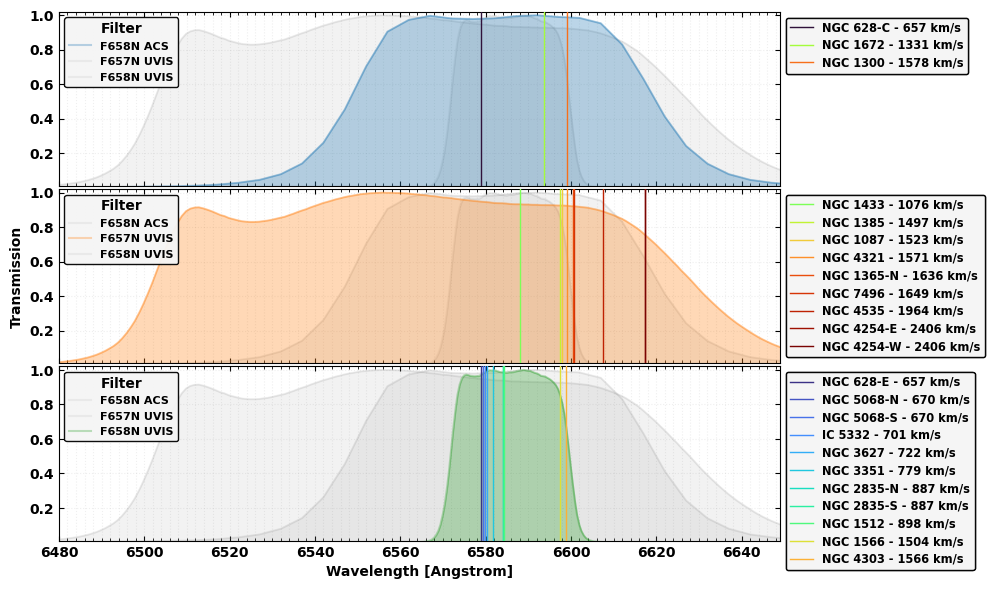

In [63]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

###
c = 'grey'
a = 0.1
a2 = 0.3

ax1.fill_between(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), alpha=a2, zorder=2, color='C0')
ax1.fill_between(t_uvis_f657n['col1'], t_uvis_f657n['col2']/t_uvis_f657n['col2'].max(), alpha=a, zorder=1, color=c)
ax1.fill_between(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), alpha=a, zorder=1, color=c)

ax1.plot(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), zorder=2, alpha=a2, color='C0')
ax1.plot(t_uvis_f657n['col1'], t_uvis_f657n['col2']/t_uvis_f657n['col2'].max(), zorder=1, alpha=a, color=c)
ax1.plot(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), zorder=1, alpha=a, color=c)

ax2.fill_between(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), alpha=a, zorder=1, color=c)
ax2.fill_between(t_uvis_f657n['col1'], t_uvis_f657n['col2']/t_uvis_f657n['col2'].max(), alpha=a2, zorder=2, color='C1')
ax2.fill_between(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), alpha=a, zorder=1, color=c)

ax2.plot(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), zorder=1, alpha=a, color=c)
ax2.plot(t_uvis_f657n['col1'], t_uvis_f657n['col2']/t_uvis_f657n['col2'].max(), zorder=2, alpha=a2, color='C1')
ax2.plot(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), zorder=1, alpha=a, color=c)


ax3.fill_between(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), alpha=a, zorder=1, color=c)
ax3.fill_between(t_uvis_f657n['col1'], t_uvis_f657n['col2']/t_uvis_f657n['col2'].max(), alpha=a, zorder=1, color=c)
ax3.fill_between(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), alpha=a2, zorder=2, color='C2')

ax3.plot(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), zorder=1, alpha=a, color=c)
ax3.plot(t_uvis_f657n['col1'], t_uvis_f657n['col2']/t_uvis_f657n['col2'].max(), zorder=1, alpha=a, color=c)
ax3.plot(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), zorder=2, alpha=a2, color='C2')
###

colors = plt.cm.turbo(np.linspace(0, 1, len(t_sample['velocity'])))
for w, v, n, f, color in zip(t_sample['reshift'].quantity.value, t_sample['velocity'].quantity.value, t_sample['galaxy'], t_sample['filter'], colors): 
    if f=='F658N ACS':
        ax1.plot([w, w], [0, 2], alpha=1, label='%s - %i km/s' %(n.upper(),v), c=color, lw=1, zorder=4)
    if f=='F657N WFC3':
        ax2.plot([w, w], [0, 2], alpha=1, label='%s - %i km/s' %(n.upper(),v), c=color, lw=1, zorder=4)
    if f=='F658N WFC3':
        ax3.plot([w, w], [0, 2], alpha=1, label='%s - %i km/s' %(n.upper(),v), c=color, lw=1, zorder=4)

for ax in [ax1, ax2, ax3]:

    lines = ax.get_lines()
    legend1 = ax.legend([lines[i] for i in [0,1,2]], ["F658N ACS", "F657N UVIS", "F658N UVIS"], 
                        fontsize=8, loc='upper left', title='Filter',
                        facecolor='whitesmoke', framealpha=0.95, edgecolor='k')
    ax.add_artist(legend1)

    lines = ax.get_lines()[2:]
    lines = [lines[i] for i in range(len(lines))]
    labels = [lines[i].get_label() for i in range(len(lines))]
    legend2 = ax.legend(lines , labels,
                        loc='upper left', fontsize=8.2,
                        facecolor='whitesmoke', framealpha=0.95, edgecolor='k', bbox_to_anchor=(1, 0., 0.5, 1))
    ax.add_artist(legend2)

    ax.grid(':', alpha=0.2, which='both')

    ax.set_xlim([6480, 6649])
    ax.set_ylim([0.01, 1.02])

    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.xaxis.set_major_locator(MultipleLocator(20))

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax3.set_xlabel('Wavelength [Angstrom]')
ax2.set_ylabel('Transmission')

fig.tight_layout(h_pad=0.02)
fig.savefig('./figs/filters.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [7]:
galaxy = 'ngc628c'

rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
infile = '%s/muse/NGC0628-0.92asec_SPEC.fits' %rootdir

hdu = fits.open(infile)[0]
spec_av = hdu.data
spec_ax = hdu.header['CRVAL1']+(np.arange(hdu.header['NAXIS1'])*hdu.header['CDELT1'])

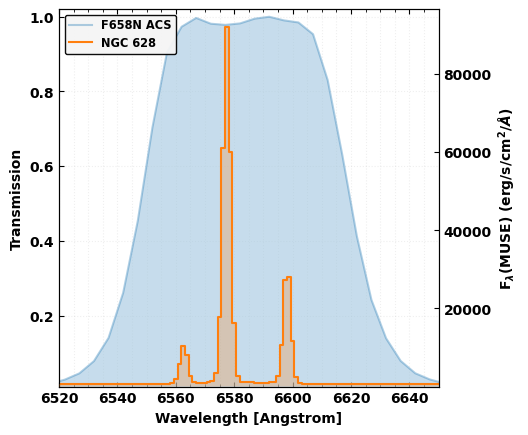

In [8]:
fig = plt.figure(figsize=(4.9,4.9))
ax = fig.add_subplot(111)
ax1 = ax.twinx()

ax.fill_between(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), alpha=0.5, zorder=2, fc='white')
ax.plot(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), zorder=2, alpha=0.35, label="F658N ACS")
ax.fill_between(t_acs_f658n['col1'], t_acs_f658n['col2']/t_acs_f658n['col2'].max(), alpha=0.25, zorder=2)

ax.plot([-1, -1], [-1,-1], ds='steps-mid',c='C1', label="NGC 628")
ax1.plot(spec_ax, spec_av, ds='steps-mid',c='C1', label="NGC 628")
ax1.fill_between(spec_ax, spec_av, alpha=0.25, fc='C1', step="mid", zorder=3)

ax.set_xlim([6520, 6650])
ax.set_ylim([0.01, 1.02])
ax1.set_ylim([0.01, np.nanmax(spec_av)*1.05])

ax.set_xlabel('Wavelength [Angstrom]')
ax.set_ylabel('Transmission')

ax.grid(':', alpha=0.2, which='both')

ax.legend(loc='upper left', fontsize=8.2, facecolor='whitesmoke', framealpha=0.95, edgecolor='k')

ax1.set_ylabel('F$_\lambda$(MUSE) (erg/s/cm$^2$/$\AA$)')

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(20))

fig.savefig('./figs/ngc628c_filters.pdf', dpi=300, bbox_inches='tight', transparent=True)